# Part 2: Cross-lingual Alignment


## Installations & Imports

In [ ]:
!pip install gensim numpy scikit-learn
!pip install numpy==1.24.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 113.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.4 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which

> !!! Please Restart the session downloading the following dependencies

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# download pre-trained embeddings for english and hindi from fastText
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
#load bilingual dict (hi-eng)
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.txt
#install numpy to deal with dependency issues

--2025-06-15 03:20:40--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.84, 13.35.37.111, 13.35.37.90, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  74.1MB/s    in 13s     

2025-06-15 03:20:53 (101 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

--2025-06-15 03:20:53--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.123, 13.35.37.90, 13.35.37.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1118942272 (1.0G) [binary/octet-stream]
Saving to: ‘cc.hi.300.vec

In [ ]:
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

## Load Embeddings -> Create Billingual Dict -> English Embedding & Hindi Embedding Matrix

In [ ]:
en_embeddings = KeyedVectors.load_word2vec_format('cc.en.300.vec.gz',limit=60000)
hi_embeddings = KeyedVectors.load_word2vec_format('cc.hi.300.vec.gz',limit=60000)


English Emebdding Stats
Vocabulary size: 60000
Vector shape: (60000, 300)
NaNs in vectors: 0
Norms: min=0.2539, max=23.1467, mean=1.2520


Hindi Emebdding Stats
Vocabulary size: 60000
Vector shape: (60000, 300)
NaNs in vectors: 0
Norms: min=0.1030, max=9.6872, mean=1.0391


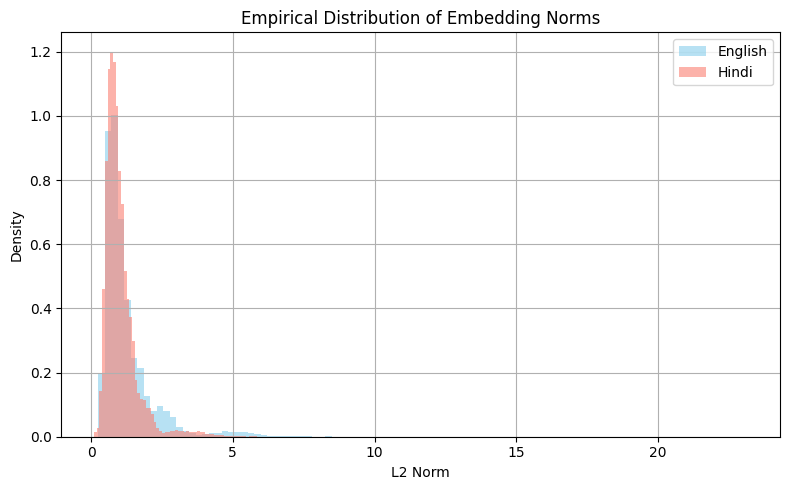

In [ ]:
def validate_and_analyze(embeddings,lang_name):
  all_vectors=np.array(list(embeddings.vectors))

  print(f"{lang_name} Emebdding Stats")
  print(f"Vocabulary size: {len(embeddings)}")
  print(f"Vector shape: {all_vectors.shape}")

  nan_check=np.isnan(all_vectors).sum()
  print(f"NaNs in vectors: {nan_check}")

  norms=np.linalg.norm(all_vectors,axis=1)
  print(f"Norms: min={norms.min():.4f}, max={norms.max():.4f}, mean={norms.mean():.4f}")
  return norms

def plot_norms(norms_en, norms_hi):
    plt.figure(figsize=(8, 5))
    plt.hist(norms_en, bins=100, alpha=0.6, label="English", color='skyblue', density=True)
    plt.hist(norms_hi, bins=100, alpha=0.6, label="Hindi", color='salmon', density=True)
    plt.xlabel("L2 Norm")
    plt.ylabel("Density")
    plt.title("Empirical Distribution of Embedding Norms")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


en_norm=validate_and_analyze(en_embeddings,"English")
print("\n")
hi_norm=validate_and_analyze(hi_embeddings,"Hindi")

plot_norms(en_norm,hi_norm)

- Embeddings are 300 dimensions
- No NaNs in the data: clean

> Fasttext vec files contain words ordered by *descending frequency*

#### Bilingual Lexicon dict  
- Creating a dictionary of tuples where (english word, corr hindi translated word)  
- to align English and Hindi embeddings


In [ ]:
bilingual_lexicon = []
with open('en-hi.txt','r') as f:
  for line in f:
    en_word,hi_word=line.strip().split()

    #only add if both words exist in their respective embedding dicts
    if en_word in en_embeddings and hi_word in hi_embeddings:
      bilingual_lexicon.append((en_word,hi_word))

print(f"total billingual pairs:{len(bilingual_lexicon)}")
print(bilingual_lexicon[:3])

total billingual pairs:16305
[('and', 'और'), ('was', 'था'), ('was', 'थी')]


#### Creating Matrix X (English Vectors) and Matrix Y (Hindi Vectors)

- Training data to learn transformation that aligns Hindi space (Y) to English space(X)

#### Splitting into train and test set

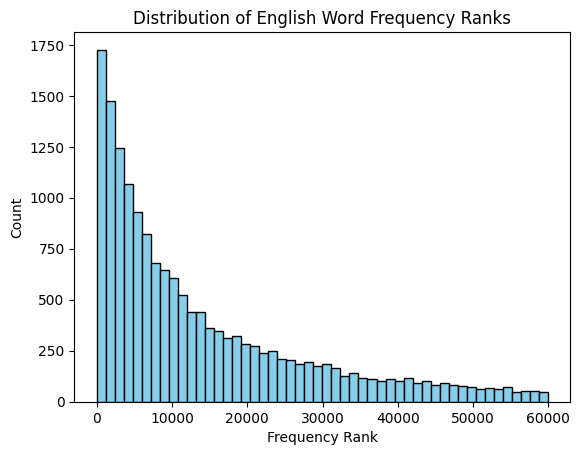

Dynamic Thresholds:
  High frequency if rank < 4709
  Mid frequency if 4709 <= rank < 15331
  Low frequency if rank >= 15331
5430
5429
5446


In [ ]:
en_freq_rank = {word: rank for rank, word in enumerate(en_embeddings.index_to_key)} # rank=0, high freq word, rank=10,000 say, less freq word

ranks = [en_freq_rank[en] for en, hi in bilingual_lexicon if en in en_freq_rank]
plt.hist(ranks, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Frequency Rank")
plt.ylabel("Count")
plt.title("Distribution of English Word Frequency Ranks")
plt.show()


low_thresh = np.percentile(ranks, 66.6)   # bottom 1/3 is low
mid_thresh = np.percentile(ranks, 33.3)   # top 1/3 is high

print(f"Dynamic Thresholds:")
print(f"  High frequency if rank < {int(mid_thresh)}")
print(f"  Mid frequency if {int(mid_thresh)} <= rank < {int(low_thresh)}")
print(f"  Low frequency if rank >= {int(low_thresh)}")



annotated_lexicon = []
for en, hi in bilingual_lexicon:
    if en in en_freq_rank:
        rank = en_freq_rank[en]
        if rank < mid_thresh:
            freq_bin = 'high'
        elif rank < low_thresh:
            freq_bin = 'mid'
        else:
            freq_bin = 'low'
        annotated_lexicon.append((en, hi, freq_bin))


# Separate by frequency bins
high = [pair for pair in annotated_lexicon if pair[2] == 'high']
mid  = [pair for pair in annotated_lexicon if pair[2] == 'mid']
low  = [pair for pair in annotated_lexicon if pair[2] == 'low']

print(len(high))
print(len(mid))
print(len(low))

# Split each bin separately (e.g., 80% train, 20% test)
train_high, test_high = train_test_split(high, test_size=0.2, random_state=42)
train_mid, test_mid   = train_test_split(mid, test_size=0.2, random_state=42)
train_low, test_low   = train_test_split(low, test_size=0.2, random_state=42)

# Combine back
train_lexicon = [(en, hi) for en, hi, _ in train_high + train_mid + train_low]
test_lexicon  = [(en, hi) for en, hi, _ in test_high + test_mid + test_low]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Extract the first English-Hindi word pair
en_word, hi_word = train_lexicon[0]

# Get their embeddings
en_vec = en_embeddings[en_word].reshape(1, -1)
hi_vec = hi_embeddings[hi_word].reshape(1, -1)

# Compute cosine similarity
cos_sim = cosine_similarity(en_vec, hi_vec)[0][0]
print(f"Cosine Similarity between '{en_word}' and '{hi_word}': {cos_sim}")

Cosine Similarity between 'closed' and 'बन्द': -0.005158914253115654


In [ ]:
X_train=np.array([en_embeddings[en] for en,hi in train_lexicon]) #English Train embedding matrix
Y_train=np.array([hi_embeddings[hi] for en,hi in train_lexicon]) #Hindi Train Embedding matrix

X_test=np.array([en_embeddings[en] for en,hi in test_lexicon]) #English Test embedding matrix
Y_test=np.array([hi_embeddings[hi] for en,hi in test_lexicon]) #Hindi Test Embedding matrix


print('English Train Embedding matrix shape:',X_train.shape)
print('Hindi Train Embedding Matrix shape:',Y_train.shape)
print('English Test Embedding matrix shape:',X_test.shape)
print('Hindi Test Embedding Matrix shape:',Y_test.shape)
#300 is the embedding dimension from fasttext

English Train Embedding matrix shape: (13043, 300)
Hindi Train Embedding Matrix shape: (13043, 300)
English Test Embedding matrix shape: (3262, 300)
Hindi Test Embedding Matrix shape: (3262, 300)


## Alignment Analysis Techniques

#### Normalize Embeddings prior to alignment

In [ ]:
X_tr_normalized=X_train/np.linalg.norm(X_train,axis=1,keepdims=True)
Y_tr_normalized=Y_train/np.linalg.norm(Y_train,axis=1,keepdims=True)

X_te_normalized=X_test/np.linalg.norm(X_test,axis=1,keepdims=True)
Y_te_normalized=Y_test/np.linalg.norm(Y_test,axis=1,keepdims=True)

## Procrustes analysis.

In [ ]:
=#align Hindi -> English
def Procrustes_alignment(X,Y):
  #X:English Embed
  #Y: Hindi Embed
  M=Y.T @ X #(d,d) #cross variance matrix
  U,S,Vt=np.linalg.svd(M) # U (d, d), S (d,), Vt (d, d) #svd
  W=U @ Vt #(d,d) #optimal orthogonal matrix W that minimizes ||Y-XW||
  Y_aligned= Y @ W #(N,d) @ (d,d)

  #check orthogonality
  I = np.eye(W.shape[0])
  orthogonality_error = np.linalg.norm(W.T @ W - I)
  print(f"Orthogonality check ‖WᵀW - I‖: {orthogonality_error:.6f}")

  return W,Y_aligned




W,Y_aligned_tr=Procrustes_alignment(X_tr_normalized,Y_tr_normalized) #train Y_aligned
Y_aligned_te=Y_te_normalized @ W #test Y_aligned

Orthogonality check ‖WᵀW - I‖: 0.000009


#### cosine similarity distribution before & after alignment
- measure of semantic alignment

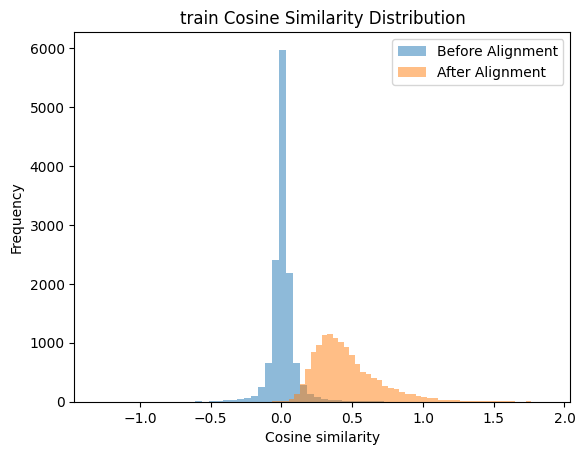

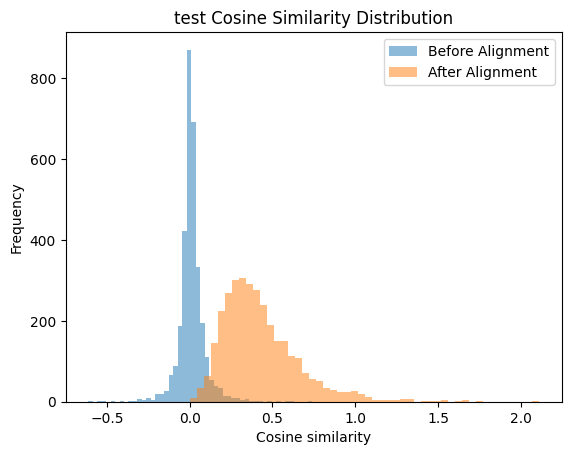

In [ ]:
def plot_cosine_similarity_distribution(X_src, Y_raw, Y_aligned, bilingual_dict,st):
    cos_before = []
    cos_after = []

    for i,(en, hi) in enumerate(bilingual_dict):
        if en in X_src and hi in Y_raw:
            x = X_src[en]
            y = Y_raw[hi]
            y_a = Y_aligned[i]

            cos_before.append(np.dot(x, y))
            cos_after.append(np.dot(x, y_a))

    plt.hist(cos_before, bins=50, alpha=0.5, label='Before Alignment')
    plt.hist(cos_after, bins=50, alpha=0.5, label='After Alignment')
    plt.title(f"{st} Cosine Similarity Distribution")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_cosine_similarity_distribution(en_embeddings,hi_embeddings,Y_aligned_tr,train_lexicon,st="train") #train

plot_cosine_similarity_distribution(en_embeddings,hi_embeddings,Y_aligned_te,test_lexicon,st="test") #test

**Obsrvations**
- **Distribution Compression** : The alignment process seems to be essentially performing **distribution compression**. Before alignment, sim tightly cluster around 0 (random relnships), but after alignment, get a *broader* more structured distribution. This suggests Procrustes isn't just rotating vectors; it's restructuring the semantic density of the embedding space.


**Observations for both train and test hists**
  
- Shift in Similarity distribtuion
- Before alignment (blue):
  - The distribution is heavily concentrated near zero cosine similarity, with a sharp peak around 0.0-0.1. This suggests that most vector pairs had little to no meaningful similarity in their original coordinate systems.
- After alignment (orange):
  - The distribution shifts significantly rightward, with the peak now around 0.3-0.4, indicating much stronger positive correlations between corresponding vectors.
  
- Improved Vector Correspondence:
  - The rightward shift demonstrates that Procrustes alignment successfully identified and corrected for rotational and scaling differences between the two vector spaces.

In [ ]:
def evaluate_alignment_precision_mrr(X_src, Y_aligned, bilingual_lexicon, top_k=1):
    correct = 0
    total = len(bilingual_lexicon)
    reciprocal_ranks = []

    #cosine similarity matrix (N x N)
    sim_matrix = cosine_similarity(Y_aligned, X_src)

    for idx in range(total):
        # indices of top_k most similar English vectors to Hindi word at idx
        sorted_indices = np.argsort(sim_matrix[idx])[::-1]
        top_indices = sorted_indices[:top_k]

        # Precision / Recall logic
        if idx in top_indices:
            correct += 1

        # MRR logic
        rank = np.where(sorted_indices == idx)[0][0] + 1  # add 1 for 1-based rank
        reciprocal_ranks.append(1 / rank)

    precision_at_k = correct / total
    recall_at_k = correct / total  # In this setup (1-to-1), precision and recall are same
    mrr = np.mean(reciprocal_ranks)

    return precision_at_k, recall_at_k, mrr


In [ ]:
def evaluate_alignment_precision_mrr(X_src, Y_aligned, bilingual_lexicon, top_k=1):
    correct = 0
    total = len(bilingual_lexicon)
    reciprocal_ranks = []

    #cosine similarity matrix (N x N)
    sim_matrix = cosine_similarity(Y_aligned, X_src)

    for idx in range(total):
        # indices of top_k most similar English vectors to Hindi word at idx
        sorted_indices = np.argsort(sim_matrix[idx])[::-1]
        top_indices = sorted_indices[:top_k]

        # Precision / Recall logic
        if idx in top_indices:
            correct += 1

        # MRR logic
        rank = np.where(sorted_indices == idx)[0][0] + 1  # add 1 for 1-based rank
        reciprocal_ranks.append(1 / rank)

    precision_at_k = correct / total
    recall_at_k = correct / total  # In this setup (1-to-1), precision and recall are same
    mrr = np.mean(reciprocal_ranks)

    return precision_at_k, recall_at_k, mrr

precision_at_1_tr,recall_at_1_tr,mrr_1_tr=evaluate_alignment_precision_mrr(X_tr_normalized,Y_aligned_tr,train_lexicon,top_k=1)
precision_at_5_tr,recall_at_5_tr,mrr_5_tr=evaluate_alignment_precision_mrr(X_tr_normalized,Y_aligned_tr,train_lexicon,top_k=5)

precision_at_1_te,recall_at_1_te,mrr_1_te=evaluate_alignment_precision_mrr(X_te_normalized,Y_aligned_te,test_lexicon,top_k=1)
precision_at_5_te,recall_at_5_te,mrr_5_te=evaluate_alignment_precision_mrr(X_te_normalized,Y_aligned_te,test_lexicon,top_k=5)


print(f"Precision@1 (train): {precision_at_1_tr:.4f}")
print(f"Recall@1 (train): {recall_at_1_tr:.4f}")
print(f"MRR (train): {mrr_1_tr:.4f}")
print("\n")
print(f"Precision@5 (train): {precision_at_5_tr:.4f}")
print(f"Recall@5 (train): {recall_at_5_tr:.4f}")
print(f"MRR (train): {mrr_5_tr:.4f}")

print("\n")
print("\n")
print(f"Precision@1 (test): {precision_at_1_te:.4f}")
print(f"Recall@1 (test): {recall_at_1_te:.4f}")
print(f"MRR (test): {mrr_1_te:.4f}")
print("\n")
print(f"Precision@5 (test): {precision_at_5_te:.4f}")
print(f"Recall@5 (test): {recall_at_5_te:.4f}")
print(f"MRR (test): {mrr_5_te:.4f}")


Precision@1 (train): 0.3978
Recall@1 (train): 0.3978
MRR (train): 0.5468


Precision@5 (train): 0.7444
Recall@5 (train): 0.7444
MRR (train): 0.5468




Precision@1 (test): 0.5457
Recall@1 (test): 0.5457
MRR (test): 0.6565


Precision@5 (test): 0.7888
Recall@5 (test): 0.7888
MRR (test): 0.6565


**Observations:**

- P@1 (≈ 39%) is moderate. This suggests that for about 4 out of 10 Hindi words, the correct English translation is ranked #1.
- P@5 jumps to ≈ 74%, meaning that in most cases, the correct translation is within the top 5, though not always at the top.
- test outperforms train
- P@5 improvement: significant jump to 74-79% shows correct translations often appear in top-5 neighbors
- MRR consistency: same values for P@1 and P@5 indicate winner takes all ranking pattern


- **Train test performance paradox** : seems counterintuitive, test precision performance outperforms train, opposite of overfitting.
  - *Hypotheiss*: Train may contain *frequency biased word pairs*. High frequency words often have more "noisy" representations due to polysemy and diverse contexts.
  
- **MRR stability @ train** for both P@1 and P@5: Indicates *winner takes all* sort of pattern, when procrustes gets the translation right, it tends to place it at 1. This suggests the transformation creates sharp decision boundaries rather than smooth similarity gradients.

- Train words: might be more polysemous and context dependent
- Test words: maybe more concrete and less ambiguous translations

- **P@5 @train =74.5** : for most word pairs, correct trnaslation often occurs in the *top 5 neighborhood*


Precision@k and Recall@k are equivalent, because each word has only one correct match, and evaluation is binary per item.

Train plot


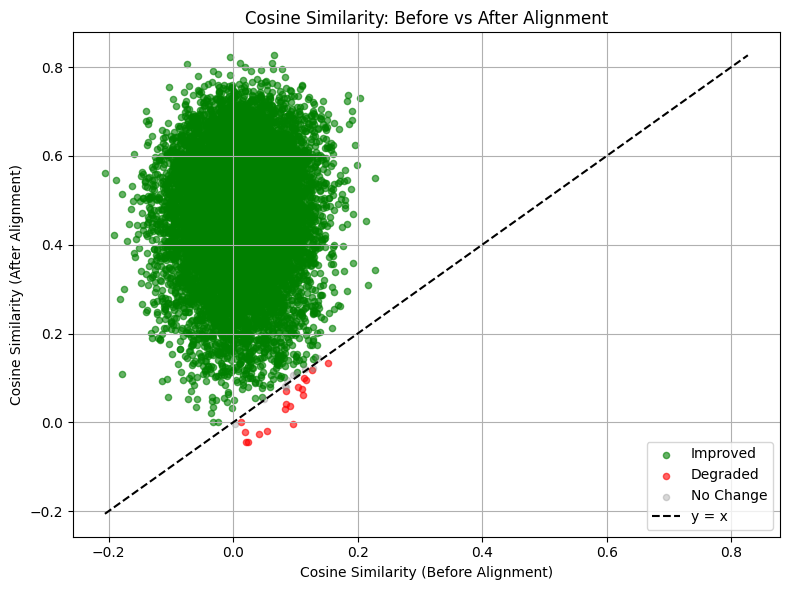

Improved: 13015 / 13043 (99.79%)
 Degraded: 18 / 13043 (0.14%)
No Change: 10 / 13043 (0.08%)
Mean Cosine Similarity — Before: 0.0101 | After: 0.4729






Test plot


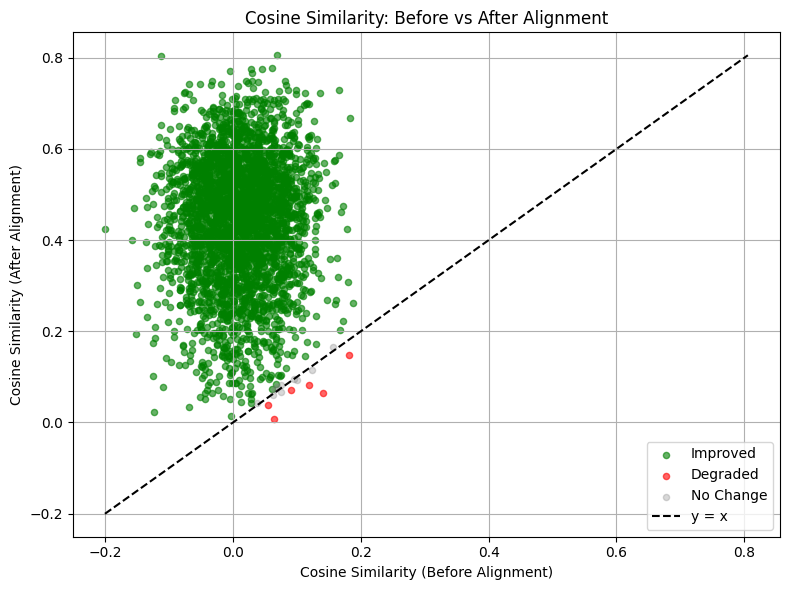

Improved: 3246 / 3262 (99.51%)
 Degraded: 6 / 3262 (0.18%)
No Change: 10 / 3262 (0.31%)
Mean Cosine Similarity — Before: 0.0103 | After: 0.4414


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
def plot_cosine_scatter_colored(X, Y, Y_aligned, lexicon, title="Cosine Similarity: Before vs After Alignment"):
    cos_before = np.array([
        cosine_similarity(X[i].reshape(1, -1), Y[i].reshape(1, -1))[0, 0]
        for i in range(len(X))
    ])
    cos_after = np.array([
        cosine_similarity(X[i].reshape(1, -1), Y_aligned[i].reshape(1, -1))[0, 0]
        for i in range(len(X))
    ])

    # Classification
    improved = cos_after > cos_before + 1e-2
    degraded = cos_after < cos_before - 1e-2
    same = ~(improved | degraded)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(cos_before[improved], cos_after[improved], color='green', alpha=0.6, label='Improved', s=20)
    plt.scatter(cos_before[degraded], cos_after[degraded], color='red', alpha=0.6, label='Degraded', s=20)
    plt.scatter(cos_before[same], cos_after[same], color='gray', alpha=0.3, label='No Change', s=20)

    # Diagonal y = x
    min_val = min(np.min(cos_before), np.min(cos_after))
    max_val = max(np.max(cos_before), np.max(cos_after))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')

    plt.xlabel("Cosine Similarity (Before Alignment)")
    plt.ylabel("Cosine Similarity (After Alignment)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Metrics
    print(f"Improved: {np.sum(improved)} / {len(improved)} ({np.mean(improved)*100:.2f}%)")
    print(f" Degraded: {np.sum(degraded)} / {len(degraded)} ({np.mean(degraded)*100:.2f}%)")
    print(f"No Change: {np.sum(same)} / {len(same)} ({np.mean(same)*100:.2f}%)")
    print(f"Mean Cosine Similarity — Before: {np.mean(cos_before):.4f} | After: {np.mean(cos_after):.4f}")


print("Train plot")
plot_cosine_scatter_colored(X_tr_normalized,Y_tr_normalized,Y_aligned_tr,train_lexicon)

print("\n")
print("\n")
print("\n")
print("Test plot")
plot_cosine_scatter_colored(X_te_normalized,Y_te_normalized,Y_aligned_te,test_lexicon)

- Train Ds
  - ~99 enhancement rate
  - extremely low failure rate
  - mean similarity 46x improvement
  - most aligned pairs achieve 0.4-0.8 similarity vs near-zero before
  - points form cluster above diganonal, i.e. good transformation quality

- Test ds
  - still exceptional rate
  - marginally higher failure than train
  - mean sim 43x improvement
  - similar clustering above diagonal


- Procrustes performs good semantic restructuring. The near all improvement suggests the alog discovered a good geometric relnship that applies broadly
- The tiny fraction of degraded pairs likely represent outliers, words that may be:
  - false friends (similar forms, but diff meanings)
  - culture specific words
  - polysemous words, where sensse differs b.w languages
  

- Dense clustering around y=x line: Most points cluster near the diagonal, but importantly, they're above it rather than on it, showing consistent improvements across similarity ranges.

> But, 99% does raise a doubt
Possible reasons as to why it might be legitmate?
- Very large, high-quality bilingual lexicon
- Robust alignment algorithm (Procrustes with regularization)
- Embeddings from similar training procedures


🔝 Top 10 Improved Word Pairs:
  ✅ sea ↔ समुद्र | Δ: 0.881 | Before: -0.074 → After: 0.807
  ✅ transfer ↔ हस्तांतरण | Δ: 0.856 | Before: -0.102 → After: 0.754
  ✅ stars ↔ तारों | Δ: 0.840 | Before: -0.139 → After: 0.701
  ✅ green ↔ हरी | Δ: 0.835 | Before: -0.056 → After: 0.779
  ✅ books ↔ किताबे | Δ: 0.828 | Before: -0.005 → After: 0.823
  ✅ prison ↔ जेल | Δ: 0.827 | Before: -0.070 → After: 0.757
  ✅ party ↔ party | Δ: 0.824 | Before: -0.097 → After: 0.727
  ✅ australian ↔ ऑस्ट्रेलियाई | Δ: 0.824 | Before: -0.079 → After: 0.745
  ✅ july ↔ जुलाई | Δ: 0.824 | Before: -0.032 → After: 0.792
  ✅ bypass ↔ बायपास | Δ: 0.818 | Before: -0.141 → After: 0.678

⚠️ Top 10 Degraded Word Pairs:
  ❌ bowler ↔ गेंदबाज | Δ: -0.099 | Before: 0.096 → After: -0.003
  ❌ liability ↔ देयता | Δ: -0.074 | Before: 0.055 → After: -0.019
  ❌ jewel ↔ गहना | Δ: -0.068 | Before: 0.024 → After: -0.044
  ❌ unaware ↔ बेखबर | Δ: -0.068 | Before: 0.042 → After: -0.026
  ❌ masks ↔ मास्क | Δ: -0.064 | Before: 0.021 → After:

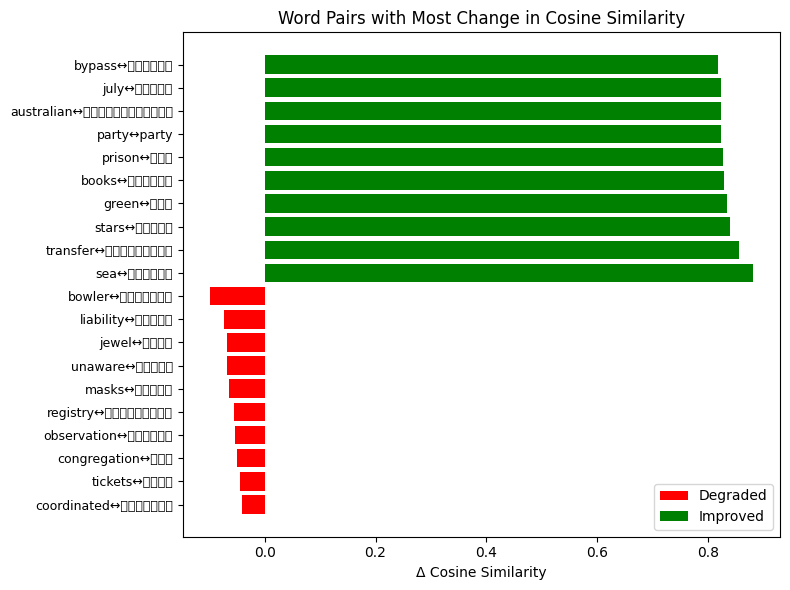

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_word_pair_alignment(X, Y, Y_aligned, bilingual_lexicon, top_n=10):
    """
    Inputs:
        X: English embeddings (N, D)
        Y: Hindi embeddings (N, D)
        Y_aligned: Aligned Hindi embeddings (N, D)
        bilingual_lexicon: List of (en_word, hi_word) pairs (length N)
        top_n: Number of top improving and degrading pairs to show
    """

    # Compute cosine similarities before and after alignment
    cos_sim_before = np.sum(X * Y, axis=1)
    cos_sim_after = np.sum(X * Y_aligned, axis=1)
    delta = cos_sim_after - cos_sim_before

    # Find top improvements and degradations
    top_improved_idx = np.argsort(-delta)[:top_n]
    top_degraded_idx = np.argsort(delta)[:top_n]

    print(f"\n🔝 Top {top_n} Improved Word Pairs:")
    for i in top_improved_idx:
        en, hi = bilingual_lexicon[i]
        print(f"  ✅ {en} ↔ {hi} | Δ: {delta[i]:.3f} | Before: {cos_sim_before[i]:.3f} → After: {cos_sim_after[i]:.3f}")

    print(f"\n⚠️ Top {top_n} Degraded Word Pairs:")
    for i in top_degraded_idx:
        en, hi = bilingual_lexicon[i]
        print(f"  ❌ {en} ↔ {hi} | Δ: {delta[i]:.3f} | Before: {cos_sim_before[i]:.3f} → After: {cos_sim_after[i]:.3f}")

    # Plot improvements and degradations
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(range(top_n), delta[top_degraded_idx][::-1], color='red', label='Degraded')
    ax.barh(range(top_n, 2*top_n), delta[top_improved_idx], color='green', label='Improved')
    labels = [f"{bilingual_lexicon[i][0]}↔{bilingual_lexicon[i][1]}" for i in top_degraded_idx[::-1]] + \
             [f"{bilingual_lexicon[i][0]}↔{bilingual_lexicon[i][1]}" for i in top_improved_idx]
    ax.set_yticks(range(2*top_n))
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel("Δ Cosine Similarity")
    ax.set_title("Word Pairs with Most Change in Cosine Similarity")
    ax.legend()
    plt.tight_layout()
    plt.show()
analyze_word_pair_alignment(X_tr_normalized,Y_tr_normalized,Y_aligned_tr,bilingual_lexicon)

In [ ]:
for en_word, hi_word in bilingual_lexicon:
    if en_word == "golfer":
        print(f"Found: {en_word} ↔ {hi_word}") #wrongly mapped by MUSE

Found: golfer ↔ मनःस्थिति


**Improved Word pairs**
- sea and books move frm **negative alignment to high alignment**
  - procrustes works well here
  - likely due to them being *common nouns and physical entities*


**Flagged Word pairs**
- bowlser degraded frm weak positive to near zero and -ve sim
  - could be because these words are *low frequency, domain specific*
  - possible mismatch in word usage too, since *bowler* for instance implies *related to cricket* in hindi, but in english it's a *slang* (fashion term)
 - Could use **context-aware embeddings* to fix this

### <a href="https://wiki.math.uwaterloo.ca/statwiki/index.php?title=Word_translation_without_parallel_data#:~:text=Cross%2DDomain%20Similarity%20Local%20Scaling%20(CSLS),-This%20paper%20considers&text=CSLS%20represents%20an%20improved%20measure,words%20in%20the%20second%20language)." >CSLS evaluation</a>

In [ ]:
def average_k_cosine_neighbors(source_vecs,target_vecs,k=10):
  sim_matrix=cosine_similarity(source_vecs,target_vecs)
  topk_sim=np.sort(sim_matrix,axis=1)[:,-k:] #top k similarities
  return np.mean(topk_sim,axis=1)

def compute_csls_scores(src_vecs,tgt_vecs,k=10):
  r_t=average_k_cosine_neighbors(src_vecs,tgt_vecs,k)
  r_s=average_k_cosine_neighbors(tgt_vecs,src_vecs,k)

  cosine_sim=cosine_similarity(src_vecs,tgt_vecs)

  csls_sim=2*cosine_sim-r_t[:,np.newaxis] - r_s[np.newaxis,:]

  return csls_sim


def evaluate_csls_alignment(X_test, Y_test, k=10):
    csls_sim = compute_csls_scores(X_test, Y_test, k=10)  # CSLS similarity scores

    # Ranking targets for each source vector
    ranks = np.argsort(-csls_sim, axis=1)  # sorted in descending order

    top1 = ranks[:, :1]
    topk = ranks[:, :k]

    correct_at_1 = 0
    correct_at_k = 0
    reciprocal_ranks = []

    for i in range(len(X_test)):
        if i in top1[i]:
            correct_at_1 += 1
        if i in topk[i]:
            correct_at_k += 1


        rank_list = ranks[i]
        correct_index = np.where(rank_list == i)[0]
        if len(correct_index) > 0:
            reciprocal_ranks.append(1 / (correct_index[0] + 1))
        else:
            reciprocal_ranks.append(0.0)

    precision_at_1 = correct_at_1 / len(X_test)
    recall_at_1 = precision_at_1  # 1-1 mapping
    precision_at_k = correct_at_k / len(X_test)
    recall_at_k = precision_at_k
    mrr = np.mean(reciprocal_ranks)

    return {
        "csls_sim": csls_sim,
        "precision@1": precision_at_1,
        "recall@1": recall_at_1,
        "precision@{}".format(k): precision_at_k,
        "recall@{}".format(k): recall_at_k,
        "MRR": mrr
    }

print("Train Metrics")
tr_5= evaluate_csls_alignment(Y_aligned_tr, X_tr_normalized, k=5)
print(f"Precision@1: {tr_5['precision@1']}")
print(f"Recall@1: {tr_5['recall@1']}")
print(f"Precision@5: {tr_5['precision@5']}")
print(f"Recall@5: {tr_5['recall@5']}")
print(f"MRR: {tr_5['MRR']}")

print("\n")
print("\n")
print("\n")

print("Test Metrics")
te_5= evaluate_csls_alignment(Y_aligned_te, X_te_normalized, k=5)
print(f"Precision@1: {te_5['precision@1']}")
print(f"Recall@1: {te_5['recall@1']}")
print(f"Precision@5: {te_5['precision@5']}")
print(f"Recall@5: {te_5['recall@5']}")
print(f"MRR: {te_5['MRR']}")




Train Metrics
Precision@1: 0.4245955685041785
Recall@1: 0.4245955685041785
Precision@5: 0.7759717856321399
Recall@5: 0.7759717856321399
MRR: 0.5755854270291636






Test Metrics
Precision@1: 0.5836909871244635
Recall@1: 0.5836909871244635
Precision@5: 0.816370324954016
Recall@5: 0.816370324954016
MRR: 0.6908506921111202


**Observations**
- P@1 is moderate, but P@5 is significantly higher
  - So the model is able to map semantically close neighs acorss languages, but struggles to precisely *rank* the exact translationa t the top
  - liley due to polysemy, or morpholoical variance. Embedding spaces may be structurally similar but not perfectly aligned at fine granularity.
  - *Implication*:  revelas alignment is good for semantic *neighborhood preservation* but not always for **precise translations** , a *limitation*
- **MRR**
  - test mrr 0.69 -> correct translation is on avg, ranked b/w **1st and 2nd posn**
  - even when p@1 fails, the right word is rarely far from the top, confirming **global str is preserved**
  - Maybe next could use **refine ranking** using reranking strategies to make adjustemnts
  

## Iterative Procrustes

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


def procrustes(X, Y):
    U, _, Vt = np.linalg.svd(X.T @ Y)
    W = U @ Vt
    return W, X.mean(axis=0), Y.mean(axis=0)


def iterative_procrustes(train_lexicon, en_embeddings, hi_embeddings,
                         X_tr_normalized, Y_tr_normalized,
                         iterations=5, vocab_limit=20000, top_k=5000):

    # Initial anchor pairs: word → index lookup
    word2idx_en = {word: i for i, word in enumerate([en for en, _ in train_lexicon])}
    word2idx_hi = {word: i for i, word in enumerate([hi for _, hi in train_lexicon])}

    anchor_pairs = [(word2idx_en[en], word2idx_hi[hi]) for en, hi in train_lexicon if en in word2idx_en and hi in word2idx_hi]

    for iter_num in range(iterations):
        print(f"\n🔁 Iteration {iter_num + 1}")

        # Construct aligned matrices
        X = np.array([X_tr_normalized[i] for i, _ in anchor_pairs])
        Y = np.array([Y_tr_normalized[j] for _, j in anchor_pairs])

        # Compute transformation
        W, Y_mean, X_mean = procrustes(Y, X) # since Hindi -> English mapping

        # Apply W to entire English normalized matrix
        aligned_Y = (Y_tr_normalized - Y_mean) @ W + X_mean # Hindi -> English

        # Compute cosine similarity
        sim_matrix = cosine_similarity(aligned_Y, X_tr_normalized)

        # Mutual Nearest Neighbors
        en2hi = sim_matrix.argmax(axis=1)
        hi2en = sim_matrix.argmax(axis=0)

        new_anchor_pairs = []
        for en_idx, hi_idx in enumerate(en2hi):
            if hi2en[hi_idx] == en_idx:
                new_anchor_pairs.append((en_idx, hi_idx))
            if len(new_anchor_pairs) >= top_k:
                break

        # Overlap with previous anchor pairs
        overlap = len(set(new_anchor_pairs) & set(anchor_pairs))
        print(f"✅ Anchor pairs updated: {len(new_anchor_pairs)} | Overlap with previous: {overlap}")

        anchor_pairs = new_anchor_pairs

    return W, anchor_pairs

W_procrustes, final_pairs = iterative_procrustes(
    train_lexicon=train_lexicon,
    en_embeddings=en_embeddings,
    hi_embeddings=hi_embeddings,
    X_tr_normalized=X_tr_normalized,
    Y_tr_normalized=Y_tr_normalized,
    iterations=20,
    vocab_limit=20000,
    top_k=5000
)



🔁 Iteration 1
✅ Anchor pairs updated: 4707 | Overlap with previous: 2772

🔁 Iteration 2
✅ Anchor pairs updated: 4495 | Overlap with previous: 4063

🔁 Iteration 3
✅ Anchor pairs updated: 4498 | Overlap with previous: 4279

🔁 Iteration 4
✅ Anchor pairs updated: 4460 | Overlap with previous: 4323

🔁 Iteration 5
✅ Anchor pairs updated: 4471 | Overlap with previous: 4343

🔁 Iteration 6
✅ Anchor pairs updated: 4449 | Overlap with previous: 4352

🔁 Iteration 7
✅ Anchor pairs updated: 4479 | Overlap with previous: 4358

🔁 Iteration 8
✅ Anchor pairs updated: 4432 | Overlap with previous: 4359

🔁 Iteration 9
✅ Anchor pairs updated: 4468 | Overlap with previous: 4341

🔁 Iteration 10
✅ Anchor pairs updated: 4439 | Overlap with previous: 4347

🔁 Iteration 11
✅ Anchor pairs updated: 4478 | Overlap with previous: 4350

🔁 Iteration 12
✅ Anchor pairs updated: 4442 | Overlap with previous: 4346

🔁 Iteration 13
✅ Anchor pairs updated: 4463 | Overlap with previous: 4334

🔁 Iteration 14
✅ Anchor pairs upd

In [ ]:
Y_aligned_tr = (Y_tr_normalized - Y_tr_normalized.mean(axis=0)) @ W_procrustes + X_tr_normalized.mean(axis=0)
Y_aligned_te = (Y_te_normalized - Y_te_normalized.mean(axis=0)) @ W_procrustes + X_te_normalized.mean(axis=0)

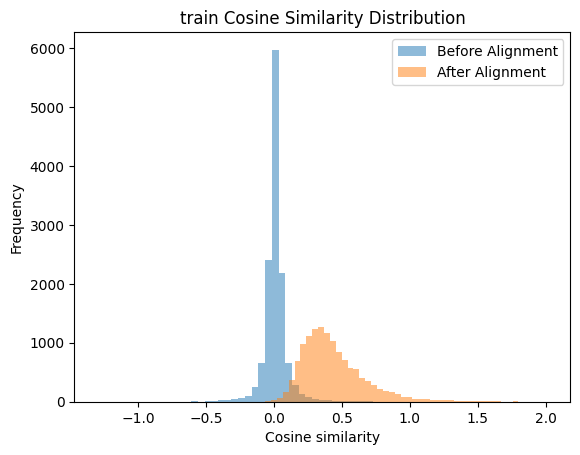

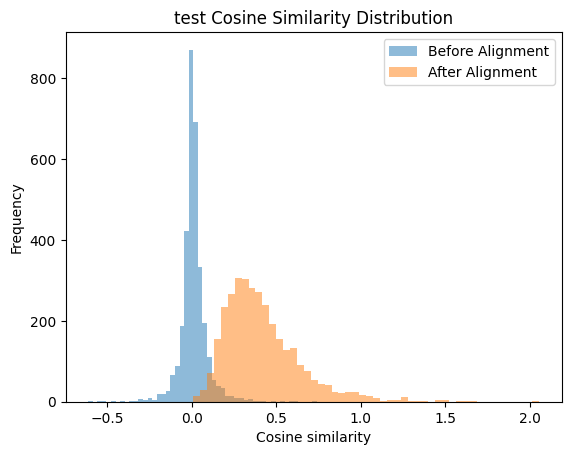

In [ ]:

plot_cosine_similarity_distribution(en_embeddings,hi_embeddings,Y_aligned_tr,train_lexicon,st="train") #train
plot_cosine_similarity_distribution(en_embeddings,hi_embeddings,Y_aligned_te,test_lexicon,st="test") #test

**Observations**
- Before alignment, distribution around 0 similarity
- After, around 0.3-0.4
-  broader, more spread out post alignment dist indicates iterative procrustes is exploring multiple optimas as compared to simple procruste

In [ ]:
precision_at_1_tr,recall_at_1_tr,mrr_1_tr=evaluate_alignment_precision_mrr(X_tr_normalized,Y_aligned_tr,train_lexicon,top_k=1)
precision_at_5_tr,recall_at_5_tr,mrr_5_tr=evaluate_alignment_precision_mrr(X_tr_normalized,Y_aligned_tr,train_lexicon,top_k=5)

precision_at_1_te,recall_at_1_te,mrr_1_te=evaluate_alignment_precision_mrr(X_te_normalized,Y_aligned_te,test_lexicon,top_k=1)
precision_at_5_te,recall_at_5_te,mrr_5_te=evaluate_alignment_precision_mrr(X_te_normalized,Y_aligned_te,test_lexicon,top_k=5)


print(f"Precision@1 (train): {precision_at_1_tr:.4f}")
print(f"Recall@1 (train): {recall_at_1_tr:.4f}")
print(f"MRR (train): {mrr_1_tr:.4f}")
print("\n")
print(f"Precision@5 (train): {precision_at_5_tr:.4f}")
print(f"Recall@5 (train): {recall_at_5_tr:.4f}")
print(f"MRR (train): {mrr_5_tr:.4f}")

print("\n")
print("\n")
print(f"Precision@1 (test): {precision_at_1_te:.4f}")
print(f"Recall@1 (test): {recall_at_1_te:.4f}")
print(f"MRR (test): {mrr_1_te:.4f}")
print("\n")
print(f"Precision@5 (test): {precision_at_5_te:.4f}")
print(f"Recall@5 (test): {recall_at_5_te:.4f}")
print(f"MRR (test): {mrr_5_te:.4f}")


Precision@1 (train): 0.3575
Recall@1 (train): 0.3575
MRR (train): 0.4941


Precision@5 (train): 0.6643
Recall@5 (train): 0.6643
MRR (train): 0.4941




Precision@1 (test): 0.5374
Recall@1 (test): 0.5374
MRR (test): 0.6444


Precision@5 (test): 0.7741
Recall@5 (test): 0.7741
MRR (test): 0.6444


- Test MRR: correct hindi word appears on average b/w *rank 1 and rank 2*
- P@1 shows more than half of the test words got their top-most pred correct
- P@1 for train lower than simple procrustes, suggests iterative steps may overfit or fail to improve early phase pairs in training

- Iterative underperforms simple procrustes
- Hypothesis: **Overoptimization paradox**: additional iterations are *chasing noise rather than signal*
  - the algo likely converged to a sol that fits training pairs too specifically, losing the *generalizable geometric insight* that simple procrustes captured in 1 step

- Iterative procrustes may have got stuck in a *suboptimal local minima*. while simple procrustes finds a gloablly reasonable soln through SVD, iterative may have *wandered off into geometric configurations* optimizing training similarity at the expense of *semantic coherence*

- To try more iterations

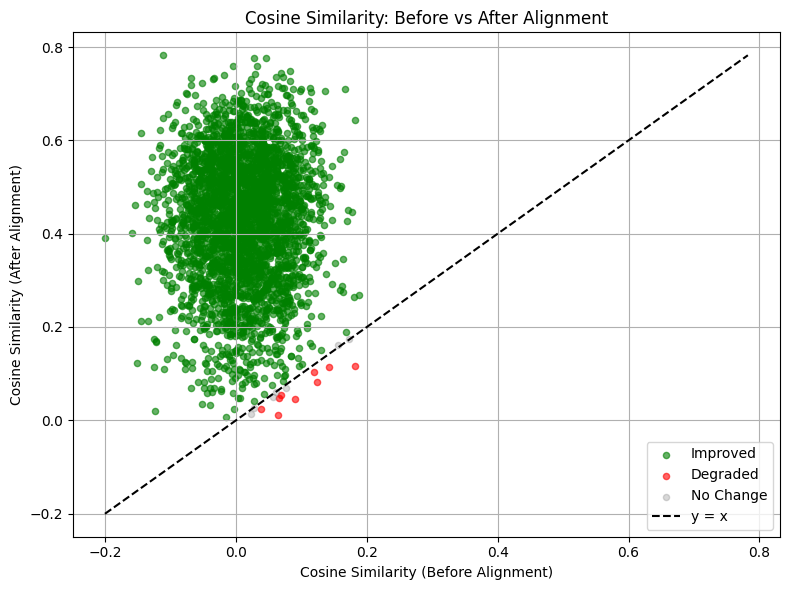

Improved: 3246 / 3262 (99.51%)
 Degraded: 9 / 3262 (0.28%)
No Change: 7 / 3262 (0.21%)
Mean Cosine Similarity — Before: 0.0103 | After: 0.4296


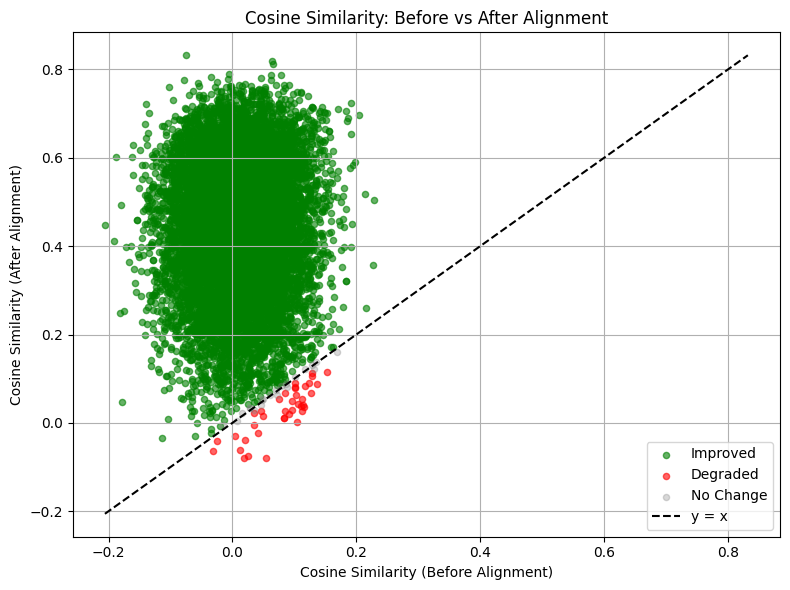

Improved: 12983 / 13043 (99.54%)
 Degraded: 39 / 13043 (0.30%)
No Change: 21 / 13043 (0.16%)
Mean Cosine Similarity — Before: 0.0101 | After: 0.4505


In [ ]:
plot_cosine_scatter_colored(X_te_normalized,Y_te_normalized,Y_aligned_te,test_lexicon)
plot_cosine_scatter_colored(X_tr_normalized,Y_tr_normalized,Y_aligned_tr,train_lexicon)

- Similar improvement rates to procrustes
- It does create *more failure cases*
  - suggests that some word pairs that would align well under simple procrustes get *destabilized by subsequent iterations*


In [ ]:
print("Train Metrics")
tr_5= evaluate_csls_alignment(Y_aligned_tr, X_tr_normalized, k=5)
print(f"Precision@1: {tr_5['precision@1']}")
print(f"Recall@1: {tr_5['recall@1']}")
print(f"Precision@5: {tr_5['precision@5']}")
print(f"Recall@5: {tr_5['recall@5']}")
print(f"MRR: {tr_5['MRR']}")

print("\n")
print("\n")
print("\n")

print("Test Metrics")
te_5= evaluate_csls_alignment(Y_aligned_te, X_te_normalized, k=5)
print(f"Precision@1: {te_5['precision@1']}")
print(f"Recall@1: {te_5['recall@1']}")
print(f"Precision@5: {te_5['precision@5']}")
print(f"Recall@5: {te_5['recall@5']}")
print(f"MRR: {te_5['MRR']}")

Train Metrics
Precision@1: 0.37736717012957144
Recall@1: 0.37736717012957144
Precision@5: 0.7007590278310205
Recall@5: 0.7007590278310205
MRR: 0.5188841450308196






Test Metrics
Precision@1: 0.5698957694665849
Recall@1: 0.5698957694665849
Precision@5: 0.8019619865113428
Recall@5: 0.8019619865113428
MRR: 0.6749303268203364


- csls boosts retrieval, especially in top-5 acc, 80% of correct words are in the top-5 on test
- MRR via csls slightly improves over cosine MRR, showsing csls' power in reducing hubness issue
- test metrics better than train


🔝 Top 10 Improved Word Pairs:
  ✅ sea ↔ समुद्र | Δ: 0.904 | Before: -0.074 → After: 0.830
  ✅ stars ↔ तारों | Δ: 0.860 | Before: -0.139 → After: 0.721
  ✅ transfer ↔ हस्तांतरण | Δ: 0.859 | Before: -0.102 → After: 0.756
  ✅ australian ↔ ऑस्ट्रेलियाई | Δ: 0.852 | Before: -0.079 → After: 0.773
  ✅ development ↔ विकास | Δ: 0.834 | Before: -0.135 → After: 0.699
  ✅ party ↔ party | Δ: 0.827 | Before: -0.097 → After: 0.730
  ✅ green ↔ हरी | Δ: 0.821 | Before: -0.056 → After: 0.765
  ✅ bypass ↔ बायपास | Δ: 0.820 | Before: -0.141 → After: 0.679
  ✅ hamlet ↔ हैमलेट | Δ: 0.815 | Before: -0.055 → After: 0.761
  ✅ found ↔ मिला | Δ: 0.813 | Before: -0.034 → After: 0.779

⚠️ Top 10 Degraded Word Pairs:
  ❌ liability ↔ देयता | Δ: -0.133 | Before: 0.055 → After: -0.078
  ❌ revelation ↔ रहस्योद्घाटन | Δ: -0.101 | Before: 0.104 → After: 0.003
  ❌ jewel ↔ गहना | Δ: -0.099 | Before: 0.024 → After: -0.074
  ❌ coordinated ↔ समन्वित | Δ: -0.099 | Before: 0.019 → After: -0.080
  ❌ curse ↔ शाप | Δ: -0.084 | Be

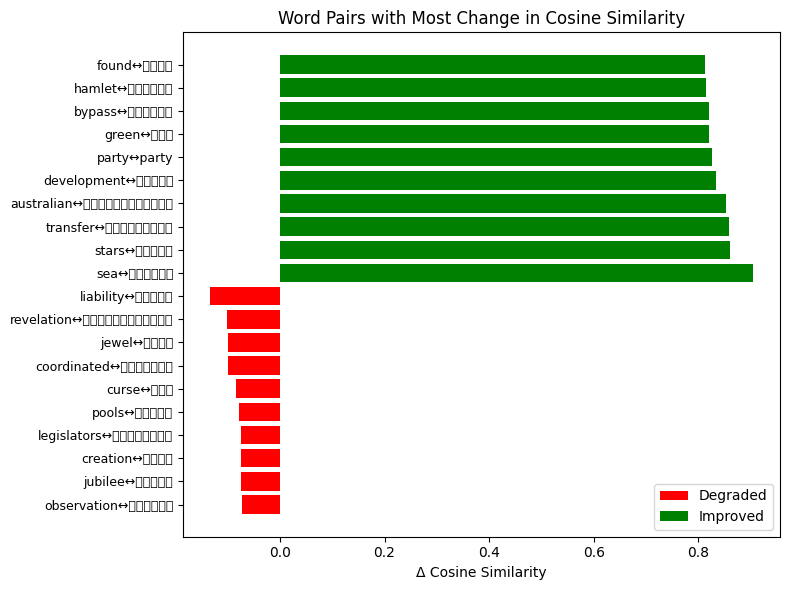

In [ ]:
analyze_word_pair_alignment(X_tr_normalized,Y_tr_normalized,Y_aligned_tr,bilingual_lexicon)

**Improvements**
- all began with negative similarities
- some words show direct borrowing
  - party -> party, hamlet -> हैमलेट, bypass -> बायपास
- iterative procrustes excels with **semanticcally unambiguous and culturally universal concepts**
- all began with -ve sims, suggesting **iterative procurstes** is effective at **rescuing severly misaligned pairs**
- iterative procrustes leverages phonetic similarities in addition to semantic ones, creating alignment advantages for loan words


**Degraded**
- some began +ve, others near zero
- cultural terms, jubilee/जयंती, technical terms coordinated/समन्वित
- struggles with **abstract and culturally nuanced concepts**
  - legal: liability/देयता, legislators/विधायकों
  - philosophical: revelation/रहस्योद्घाटन, creation/सृजन, curse/शाप
  - cultural: jubillee

- destabilizes culturally specific translations
- degraded pairs had *modest +ve* starting sims, rather than -ve ones. suggests it **overcorrects modereately good alignments**
- degraded words tend to be **morphologically complex** or **culturally loaded**. struggles with **semantic complexity**


## Unsupervised Alignment using Discriminator

### Mutiple (Failed) Attempts of Adversarial Alignment + Iterative Procrustes from https://arxiv.org/pdf/1710.04087

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.optim as optim

#clsls fn
def compute_csls(src_emb, tgt_emb, k=10):
    similarities = cosine_similarity(src_emb, tgt_emb)
    src_avg_sim = np.mean(np.sort(similarities, axis=1)[:, -k:], axis=1)
    tgt_avg_sim = np.mean(np.sort(similarities.T, axis=1)[:, -k:], axis=1)
    csls_similarities = 2 * similarities.T - src_avg_sim - tgt_avg_sim[:, np.newaxis]
    return csls_similarities.T

#map net
class MappingNetwork(nn.Module):
    def __init__(self, embedding_dim):
        super(MappingNetwork, self).__init__()
        self.mapping = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x):
        return self.mapping(x)

# disc net
class Discriminator(nn.Module):
    def __init__(self, embedding_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1)

# adversarial tr
def adversarial_training(src_emb, tgt_emb, mapping_net, discriminator, num_epochs=15, batch_size=64, lr=0.001):
    mapping_optimizer = optim.Adam(mapping_net.parameters(), lr=lr)
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    src_emb = torch.tensor(src_emb, dtype=torch.float32)
    tgt_emb = torch.tensor(tgt_emb, dtype=torch.float32)

    for epoch in range(num_epochs):
        permutation = torch.randperm(src_emb.size(0))
        src_emb = src_emb[permutation]
        tgt_emb = tgt_emb[permutation]

        for i in range(0, len(src_emb), batch_size):
            src_batch = src_emb[i:i+batch_size]
            tgt_batch = tgt_emb[i:i+batch_size]

            #disc
            src_labels = torch.zeros(src_batch.size(0))
            tgt_labels = torch.ones(tgt_batch.size(0))

            discriminator_optimizer.zero_grad()
            mapped_src = mapping_net(src_batch)

            pred_src = discriminator(mapped_src.detach())
            pred_tgt = discriminator(tgt_batch)

            loss_d = loss_fn(pred_src, src_labels) + loss_fn(pred_tgt, tgt_labels)
            loss_d.backward()
            discriminator_optimizer.step()

            #map
            mapping_optimizer.zero_grad()
            pred_src = discriminator(mapping_net(src_batch))
            loss_g = loss_fn(pred_src, tgt_labels)  # Fool the discriminator
            loss_g.backward()
            mapping_optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} | Discriminator Loss: {loss_d.item():.4f} | Generator Loss: {loss_g.item():.4f}")
        with torch.no_grad():
          beta = 0.01
          W = mapping_net.mapping.weight.data
          mapping_net.mapping.weight.copy_((1 + beta) * W - beta * W @ W.T @ W)

    return mapping_net




embedding_dim = X_tr_normalized.shape[1]
mapping_net = MappingNetwork(embedding_dim)
discriminator = Discriminator(embedding_dim)

# train adversarial mapping
mapping_net = adversarial_training(Y_tr_normalized, X_tr_normalized, mapping_net, discriminator)

Y_aligned_te = mapping_net(torch.tensor(Y_te_normalized, dtype=torch.float32)).detach().numpy()
Y_aligned_tr = mapping_net(torch.tensor(Y_tr_normalized, dtype=torch.float32)).detach().numpy()

W_refined, final_anchor_pairs = iterative_procrustes(
    train_lexicon=train_lexicon,
    en_embeddings=en_embeddings,
    hi_embeddings=hi_embeddings,
    X_tr_normalized=X_tr_normalized,
    Y_tr_normalized=Y_aligned_tr,             # mapping hindi from adversarial step
    iterations=10,
    vocab_limit=20000,
    top_k=5000
)


Y_aligned_tr = (Y_tr_normalized - Y_tr_normalized.mean(axis=0)) @ W_refined + X_tr_normalized.mean(axis=0)
Y_aligned_te = (Y_te_normalized - Y_te_normalized.mean(axis=0)) @ W_refined + X_te_normalized.mean(axis=0)


Epoch 1/15 | Discriminator Loss: 0.5940 | Generator Loss: 2.6831
Epoch 2/15 | Discriminator Loss: 1.3372 | Generator Loss: 0.8960
Epoch 3/15 | Discriminator Loss: 1.3295 | Generator Loss: 0.8153
Epoch 4/15 | Discriminator Loss: 1.3707 | Generator Loss: 0.7195
Epoch 5/15 | Discriminator Loss: 1.3779 | Generator Loss: 0.6870
Epoch 6/15 | Discriminator Loss: 1.3633 | Generator Loss: 0.7646
Epoch 7/15 | Discriminator Loss: 1.3780 | Generator Loss: 0.6970
Epoch 8/15 | Discriminator Loss: 1.4071 | Generator Loss: 0.6676
Epoch 9/15 | Discriminator Loss: 1.3426 | Generator Loss: 0.7871
Epoch 10/15 | Discriminator Loss: 1.1078 | Generator Loss: 1.1393
Epoch 11/15 | Discriminator Loss: 1.1977 | Generator Loss: 0.9895
Epoch 12/15 | Discriminator Loss: 1.0837 | Generator Loss: 1.1445
Epoch 13/15 | Discriminator Loss: 1.3822 | Generator Loss: 0.7954
Epoch 14/15 | Discriminator Loss: 1.4870 | Generator Loss: 0.6129
Epoch 15/15 | Discriminator Loss: 1.4493 | Generator Loss: 0.6272

🔁 Iteration 1
✅ An

In [ ]:
precision_at_1_tr,recall_at_1_tr,mrr_1_tr=evaluate_alignment_precision_mrr(X_tr_normalized,Y_aligned_tr,train_lexicon,top_k=1)
precision_at_5_tr,recall_at_5_tr,mrr_5_tr=evaluate_alignment_precision_mrr(X_tr_normalized,Y_aligned_tr,train_lexicon,top_k=5)

precision_at_1_te,recall_at_1_te,mrr_1_te=evaluate_alignment_precision_mrr(X_te_normalized,Y_aligned_te,test_lexicon,top_k=1)
precision_at_5_te,recall_at_5_te,mrr_5_te=evaluate_alignment_precision_mrr(X_te_normalized,Y_aligned_te,test_lexicon,top_k=5)


print(f"Precision@1 (train): {precision_at_1_tr:.4f}")
print(f"Recall@1 (train): {recall_at_1_tr:.4f}")
print(f"MRR (train): {mrr_1_tr:.4f}")
print("\n")
print(f"Precision@5 (train): {precision_at_5_tr:.4f}")
print(f"Recall@5 (train): {recall_at_5_tr:.4f}")
print(f"MRR (train): {mrr_5_tr:.4f}")

print("\n")
print("\n")
print(f"Precision@1 (test): {precision_at_1_te:.4f}")
print(f"Recall@1 (test): {recall_at_1_te:.4f}")
print(f"MRR (test): {mrr_1_te:.4f}")
print("\n")
print(f"Precision@5 (test): {precision_at_5_te:.4f}")
print(f"Recall@5 (test): {recall_at_5_te:.4f}")
print(f"MRR (test): {mrr_5_te:.4f}")


Precision@1 (train): 0.0000
Recall@1 (train): 0.0000
MRR (train): 0.0006


Precision@5 (train): 0.0002
Recall@5 (train): 0.0002
MRR (train): 0.0006




Precision@1 (test): 0.0000
Recall@1 (test): 0.0000
MRR (test): 0.0022


Precision@5 (test): 0.0009
Recall@5 (test): 0.0009
MRR (test): 0.0022


In [ ]:
print("Train Metrics")
tr_5= evaluate_csls_alignment(Y_aligned_tr, X_tr_normalized, k=5)
print(f"Precision@1: {tr_5['precision@1']}")
print(f"Recall@1: {tr_5['recall@1']}")
print(f"Precision@5: {tr_5['precision@5']}")
print(f"Recall@5: {tr_5['recall@5']}")
print(f"MRR: {tr_5['MRR']}")

print("\n")
print("\n")
print("\n")

print("Test Metrics")
te_5= evaluate_csls_alignment(Y_aligned_te, X_te_normalized, k=5)
print(f"Precision@1: {te_5['precision@1']}")
print(f"Recall@1: {te_5['recall@1']}")
print(f"Precision@5: {te_5['precision@5']}")
print(f"Recall@5: {te_5['recall@5']}")
print(f"MRR: {te_5['MRR']}")

Train Metrics
Precision@1: 0.0
Recall@1: 0.0
Precision@5: 0.00030667791152342254
Recall@5: 0.00030667791152342254
MRR: 0.0006265745991938695






Test Metrics
Precision@1: 0.00030656039239730225
Recall@1: 0.00030656039239730225
Precision@5: 0.0015328019619865114
Recall@5: 0.0015328019619865114
MRR: 0.0024738841561653445


>> the model has failed completely both across cosine and csls based retrieval scaores
- No alignment learned
- Even mrr is 0.0002, which implies correct ranslation is on avg ranked ~500th or lower
- WORSE than random guessing


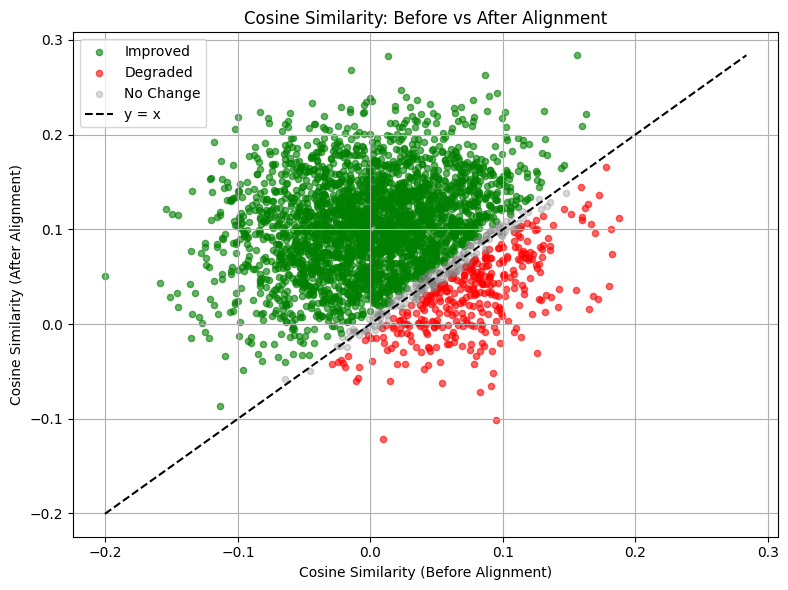

Improved: 2740 / 3262 (84.00%)
 Degraded: 341 / 3262 (10.45%)
No Change: 181 / 3262 (5.55%)
Mean Cosine Similarity — Before: 0.0103 | After: 0.0945


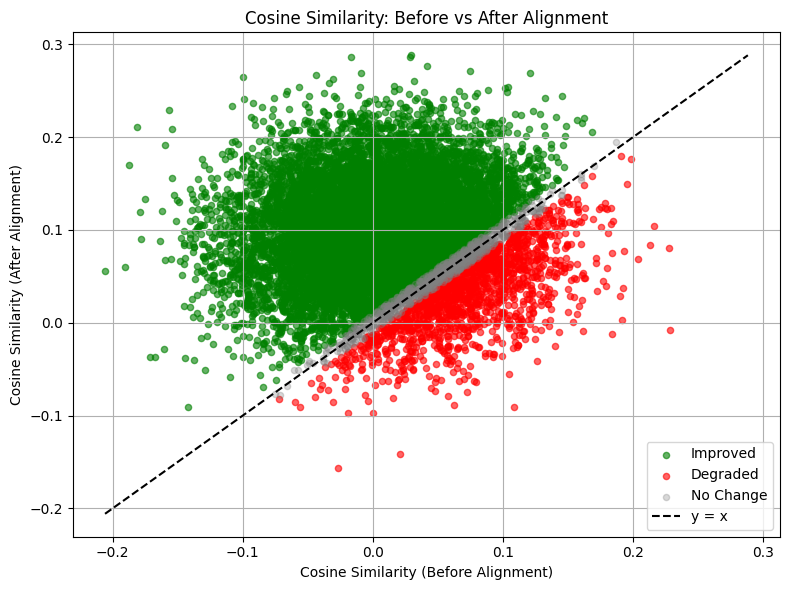

Improved: 10856 / 13043 (83.23%)
 Degraded: 1407 / 13043 (10.79%)
No Change: 780 / 13043 (5.98%)
Mean Cosine Similarity — Before: 0.0101 | After: 0.0933


In [ ]:
plot_cosine_scatter_colored(X_te_normalized,Y_te_normalized,Y_aligned_te,test_lexicon)
plot_cosine_scatter_colored(X_tr_normalized,Y_tr_normalized,Y_aligned_tr,train_lexicon)

- Scatter plots reveal catestrophic failing
- failure generalizes from train to test
- clusters below y=x reveal W isnt learning anything meaningful

## VecMap

### Vecmap unsupervised - failed attempt

In [1]:
# import torch
# import torch.nn.functional as F
# from typing import Tuple, Optional


# def get_device() -> torch.device:
#     """Get the best available device (CUDA if available, else CPU)"""
#     return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# def to_tensor(x, device: Optional[torch.device] = None) -> torch.Tensor:
#     """Convert numpy array to PyTorch tensor on specified device"""
#     if device is None:
#         device = get_device()
#     if isinstance(x, torch.Tensor):
#         return x.to(device)
#     return torch.tensor(x, dtype=torch.float32, device=device)


# def normalize_embeddings(X: torch.Tensor) -> torch.Tensor:
#     """
#     Normalize embeddings: L2 normalize -> mean center -> L2 normalize again
#     """
#     # L2 normalize along dimension 1 (each row)
#     X = F.normalize(X, p=2, dim=1)

#     # Mean center
#     X = X - torch.mean(X, dim=0, keepdim=True)

#     # L2 normalize again
#     X = F.normalize(X, p=2, dim=1)

#     return X

# def compute_self_similarity(X: torch.Tensor) -> torch.Tensor:
#     """Compute self-similarity matrix X @ X.T"""
#     return torch.mm(X, X.T)


# def sorted_sqrt_similarity(X: torch.Tensor) -> torch.Tensor:
#     """
#     Compute sorted square root of similarity matrix using SVD
#     """
#     # Compute SVD
#     U, S, _ = torch.linalg.svd(X, full_matrices=False)

#     # Compute sqrt similarity matrix
#     sqrt_S = torch.sqrt(torch.clamp(S, min=1e-8))  # Clamp to avoid numerical issues
#     sqrt_sim = torch.mm(torch.mm(U, torch.diag(sqrt_S)), U.T)

#     # Sort along dimension 1
#     sqrt_sim_sorted, _ = torch.sort(sqrt_sim, dim=1)

#     return sqrt_sim_sorted


# def build_initial_dictionary(Xp: torch.Tensor, Zp: torch.Tensor) -> torch.Tensor:
#     """
#     Build initial dictionary using nearest neighbors
#     """
#     # Compute similarity matrix
#     sim = torch.mm(Xp, Zp.T)

#     # Find nearest neighbors
#     nn = torch.argmax(sim, dim=1)

#     # Build dictionary matrix
#     D = torch.zeros((Xp.shape[0], Zp.shape[0]), device=Xp.device)
#     D[torch.arange(Xp.shape[0], device=Xp.device), nn] = 1

#     return D


# def compute_csls_sim(X: torch.Tensor, Z: torch.Tensor, knn: int = 10) -> torch.Tensor:
#     """
#     Compute Cross-domain Similarity Local Scaling (CSLS) similarity
#     """
#     # Compute similarity matrix
#     sim = torch.mm(X, Z.T)

#     # Compute rT: mean of top-k similarities for each row
#     sim_sorted, _ = torch.sort(sim, dim=1, descending=True)
#     rT = torch.mean(sim_sorted[:, :knn], dim=1)

#     # Compute rS: mean of top-k similarities for each column (transpose)
#     sim_T_sorted, _ = torch.sort(sim.T, dim=1, descending=True)
#     rS = torch.mean(sim_T_sorted[:, :knn], dim=1)

#     # Compute CSLS similarity
#     csls_sim = 2 * sim - rT.unsqueeze(1) - rS.unsqueeze(0)

#     return csls_sim


# def induce_dictionary_csls(X: torch.Tensor, Z: torch.Tensor) -> torch.Tensor:
#     """
#     Induce dictionary using CSLS with bidirectional matching
#     """
#     # Forward direction: X -> Z
#     sim = compute_csls_sim(X, Z)
#     nn = torch.argmax(sim, dim=1)
#     D = torch.zeros((X.shape[0], Z.shape[0]), device=X.device)
#     D[torch.arange(X.shape[0], device=X.device), nn] = 1

#     # Reverse direction: Z -> X
#     sim_rev = compute_csls_sim(Z, X)
#     nn_rev = torch.argmax(sim_rev, dim=1)
#     D_rev = torch.zeros((X.shape[0], Z.shape[0]), device=X.device)
#     D_rev[nn_rev, torch.arange(Z.shape[0], device=Z.device)] = 1

#     return D + D_rev


# def orthogonal_procrustes(X: torch.Tensor, Z: torch.Tensor, D: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#     """
#     Solve orthogonal Procrustes problem using SVD
#     """
#     # Compute A = X.T @ D @ Z
#     A = torch.mm(torch.mm(X.T, D), Z)

#     # SVD decomposition
#     U, _, Vt = torch.linalg.svd(A, full_matrices=False)

#     return U, Vt


# def self_learning(X: torch.Tensor, Z: torch.Tensor, D_init: torch.Tensor, max_iter: int = 100) -> Tuple[torch.Tensor, torch.Tensor]:
#     """
#     Self-learning iterative procedure
#     """
#     device = X.device

#     # Initialize transformation matrices
#     WX = torch.eye(X.shape[1], device=device)
#     WZ = torch.eye(Z.shape[1], device=device)
#     D = D_init.clone()
#     prev_obj = float('-inf')

#     for i in range(max_iter):
#         # Solve orthogonal Procrustes problem
#         U, V = orthogonal_procrustes(X, Z, D)
#         WX = U
#         WZ = V

#         # Apply transformations
#         X_mapped = torch.mm(X, WX)
#         Z_mapped = torch.mm(Z, WZ)

#         # Update dictionary using CSLS
#         D = induce_dictionary_csls(X_mapped, Z_mapped)

#         # Compute objective (alignment quality)
#         obj = torch.sum(torch.mm(X_mapped, Z_mapped.T) * D).item()

#         # Check convergence
#         if abs(obj - prev_obj) < 1e-6:
#             print(f"Converged after {i+1} iterations")
#             break
#         prev_obj = obj

#     return WX, WZ

# # -
# def symmetric_reweighting(X: torch.Tensor, Z: torch.Tensor, D: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#     """
#     Apply symmetric reweighting using SVD
#     """
#     # Compute A = X.T @ D @ Z
#     A = torch.mm(torch.mm(X.T, D), Z)

#     # SVD decomposition
#     U, S, Vt = torch.linalg.svd(A, full_matrices=False)

#     # Compute symmetric weights
#     sqrt_S = torch.sqrt(torch.clamp(S, min=1e-8))
#     WX = torch.mm(U, torch.diag(sqrt_S))
#     WZ = torch.mm(Vt.T, torch.diag(sqrt_S))

#     return WX, WZ

# def vecmap_unsupervised_pipeline(X, Z, device: Optional[torch.device] = None) -> Tuple[torch.Tensor, torch.Tensor]:
#     """
#     Complete VecMap unsupervised pipeline

#     Args:
#         X: Source language embeddings (numpy array or torch tensor)
#         Z: Target language embeddings (numpy array or torch tensor)
#         device: Device to run computations on (auto-detected if None)

#     Returns:
#         WX_final: Final transformation matrix for X
#         WZ_final: Final transformation matrix for Z
#     """
#     if device is None:
#         device = get_device()

#     print(f"Using device: {device}")

#     # Convert to tensors and move to device
#     X = to_tensor(X, device)
#     Z = to_tensor(Z, device)

#     print("Step 1: Normalizing embeddings...")
#     # Step 1: Normalize embeddings
#     X = normalize_embeddings(X)
#     Z = normalize_embeddings(Z)

#     print("Step 2: Computing initial dictionary...")
#     # Step 2: Unsupervised initialization
#     MX_sqrt_sorted = sorted_sqrt_similarity(X)
#     MZ_sqrt_sorted = sorted_sqrt_similarity(Z)
#     Xp = normalize_embeddings(MX_sqrt_sorted)
#     Zp = normalize_embeddings(MZ_sqrt_sorted)
#     D_init = build_initial_dictionary(Xp, Zp)

#     print("Step 3: Self-learning...")
#     # Step 3: Self-learning with CSLS
#     WX, WZ = self_learning(X, Z, D_init)

#     print("Step 4: Symmetric reweighting...")
#     # Step 4: Symmetric reweighting
#     X_mapped = torch.mm(X, WX)
#     Z_mapped = torch.mm(Z, WZ)
#     D_final = induce_dictionary_csls(X_mapped, Z_mapped)
#     WX_final, WZ_final = symmetric_reweighting(X, Z, D_final)

#     return WX_final, WZ_final

### Vecmap supervised

In [ ]:
import torch
import torch.nn.functional as F
from typing import Tuple, Optional
import numpy as np

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_tensor(x, device: Optional[torch.device] = None):
    if device is None:
        device = get_device()
    if isinstance(x, torch.Tensor):
        return x.to(device)
    return torch.tensor(x, dtype=torch.float32, device=device)


# normalization
def normalize_embeddings(X: torch.Tensor) -> torch.Tensor:
    X = F.normalize(X, p=2, dim=1)
    X = X - torch.mean(X, dim=0, keepdim=True)
    X = F.normalize(X, p=2, dim=1)
    return X

# orthogonal Procrustes
def orthogonal_procrustes(X: torch.Tensor, Y: torch.Tensor, D: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    A = torch.mm(torch.mm(X.T, D), Y)
    U, _, Vt = torch.linalg.svd(A, full_matrices=False)
    return U, Vt


# symmetric reweighting
def symmetric_reweighting(X: torch.Tensor, Y: torch.Tensor, D: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    A = torch.mm(torch.mm(X.T, D), Y)
    U, S, Vt = torch.linalg.svd(A, full_matrices=False)
    sqrt_S = torch.sqrt(torch.clamp(S, min=1e-8))
    WX = torch.mm(U, torch.diag(sqrt_S))
    WZ = torch.mm(Vt.T, torch.diag(sqrt_S))
    return WX, WZ

# supervised vecmap
def vecmap_supervised_from_matrices(X: np.ndarray, Y: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
    device = get_device()
    X = to_tensor(X, device)
    Y = to_tensor(Y, device)

    X = normalize_embeddings(X)
    Y = normalize_embeddings(Y)

    D = torch.eye(X.shape[0], device=device)

    U, V = orthogonal_procrustes(X, Y, D)
    WX = U
    WZ = V

    WX_final, WZ_final = symmetric_reweighting(X, Y, D)
    return WX_final, WZ_final

In [ ]:
W_x,W_y=vecmap_supervised_from_matrices(X_train,Y_train)

In [ ]:
W_x=W_x.to("cpu").numpy()
W_y=W_y.to("cpu").numpy()

In [ ]:
X_aligned_tr = X_train @ W_x
Y_aligned_tr = Y_train @ W_y
X_aligned_te = X_test @ W_x
Y_aligned_te = Y_test @ W_y

In [ ]:
precision_at_1_tr,recall_at_1_tr,mrr_1_tr=evaluate_alignment_precision_mrr(X_aligned_tr,Y_aligned_tr,train_lexicon,top_k=1)
precision_at_5_tr,recall_at_5_tr,mrr_5_tr=evaluate_alignment_precision_mrr(X_aligned_tr,Y_aligned_tr,train_lexicon,top_k=5)

precision_at_1_te,recall_at_1_te,mrr_1_te=evaluate_alignment_precision_mrr(X_aligned_te,Y_aligned_te,test_lexicon,top_k=1)
precision_at_5_te,recall_at_5_te,mrr_5_te=evaluate_alignment_precision_mrr(X_aligned_te,Y_aligned_te,test_lexicon,top_k=5)


print(f"Precision@1 (train): {precision_at_1_tr:.4f}")
print(f"Recall@1 (train): {recall_at_1_tr:.4f}")
print(f"MRR (train): {mrr_1_tr:.4f}")
print("\n")
print(f"Precision@5 (train): {precision_at_5_tr:.4f}")
print(f"Recall@5 (train): {recall_at_5_tr:.4f}")
print(f"MRR (train): {mrr_5_tr:.4f}")

print("\n")
print("\n")
print(f"Precision@1 (test): {precision_at_1_te:.4f}")
print(f"Recall@1 (test): {recall_at_1_te:.4f}")
print(f"MRR (test): {mrr_1_te:.4f}")
print("\n")
print(f"Precision@5 (test): {precision_at_5_te:.4f}")
print(f"Recall@5 (test): {recall_at_5_te:.4f}")
print(f"MRR (test): {mrr_5_te:.4f}")


Precision@1 (train): 0.2943
Recall@1 (train): 0.2943
MRR (train): 0.4209


Precision@5 (train): 0.5749
Recall@5 (train): 0.5749
MRR (train): 0.4209




Precision@1 (test): 0.4464
Recall@1 (test): 0.4464
MRR (test): 0.5512


Precision@5 (test): 0.6698
Recall@5 (test): 0.6698
MRR (test): 0.5512


- performs better on test
- The Mean Reciprocal Rank (MRR) sits around 0.55–0.60 on the test set, meaning correct translations often show up among the top 1–2 positions.


In [ ]:
print("Train Metrics")
tr_5= evaluate_csls_alignment(Y_aligned_tr, X_aligned_tr, k=5)
print(f"Precision@1: {tr_5['precision@1']}")
print(f"Recall@1: {tr_5['recall@1']}")
print(f"Precision@5: {tr_5['precision@5']}")
print(f"Recall@5: {tr_5['recall@5']}")
print(f"MRR: {tr_5['MRR']}")

print("\n")
print("\n")
print("\n")

print("Test Metrics")
te_5= evaluate_csls_alignment(Y_aligned_te, X_aligned_te, k=5)
print(f"Precision@1: {te_5['precision@1']}")
print(f"Recall@1: {te_5['recall@1']}")
print(f"Precision@5: {te_5['precision@5']}")
print(f"Recall@5: {te_5['recall@5']}")
print(f"MRR: {te_5['MRR']}")

Train Metrics
Precision@1: 0.3411025070919267
Recall@1: 0.3411025070919267
Precision@5: 0.6402668097830254
Recall@5: 0.6402668097830254
MRR: 0.4737794691254049






Test Metrics
Precision@1: 0.5064377682403434
Recall@1: 0.5064377682403434
Precision@5: 0.7265481299816063
Recall@5: 0.7265481299816063
MRR: 0.6088551505361458


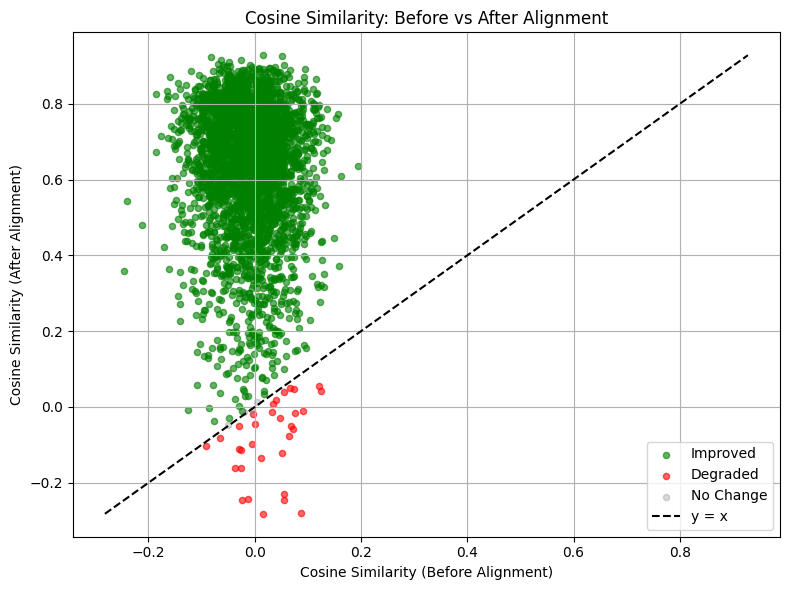

Improved: 3226 / 3262 (98.90%)
 Degraded: 32 / 3262 (0.98%)
No Change: 4 / 3262 (0.12%)
Mean Cosine Similarity — Before: -0.0102 | After: 0.6249


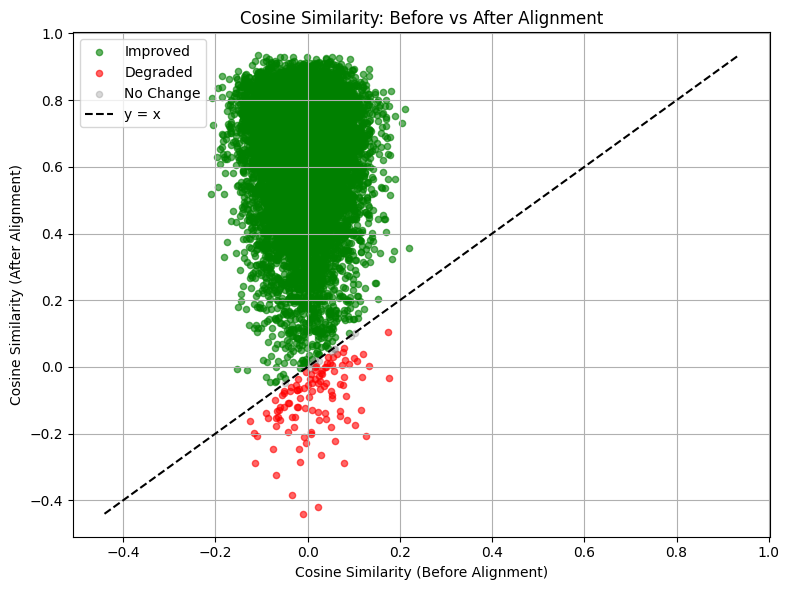

Improved: 12923 / 13043 (99.08%)
 Degraded: 110 / 13043 (0.84%)
No Change: 10 / 13043 (0.08%)
Mean Cosine Similarity — Before: -0.0092 | After: 0.6383


In [ ]:
plot_cosine_scatter_colored(X_aligned_te,Y_te_normalized,Y_aligned_te,test_lexicon)
plot_cosine_scatter_colored(X_aligned_tr,Y_tr_normalized,Y_aligned_tr,train_lexicon)